<a href="https://colab.research.google.com/github/netaamz/DL-Model-for-Automated-Detection-of-Meniscus-Tears-in-Knee-MRI-Images/blob/main/ephocs_3_planes_concatenate_DenseNet_transfer_learning_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone: Development of an algorithm for automatic detection of meniscus tears in radiographic images of the knee.

In [1]:
import warnings
warnings.filterwarnings("ignore")

#!pip install pyyaml

In [2]:

!pip install tensorflow
!pip install keras
!pip install h5py
!pip install sklearn
!pip install opencv-python
!pip install seaborn
!pip install matplotlib
!pip install numpy

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [3]:
# Import libraries here
import os
import tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from glob import glob
from IPython.display import Image, display
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score

import random as random
import imageio
import imgaug as ia
import tensorflow as tf
from tensorflow import keras
pd.options.mode.chained_assignment = None  # default='warn'


## Data import

**import data and get labels**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The dataset contains *s* x 256 x 256 images. Since middle images are the most useful, only 3 middle slides in the series are retained.


## **data generation for meniscus**

In [5]:
def data_gen(dataset_type, plane, diagnosis):
    '''this function gets the data from the extracted datset'''
    # for eg, (train, sagittal, mensicus)
    if dataset_type == 'train':
        go = '/content/drive/My Drive/miniscus data set/MRNet-v1.0/train_transformf' # if we want without filter then:  /content/drive/My Drive/miniscus data set/MRNet-v1.0/train_transform
    else:
        go = '/content/drive/My Drive/miniscus data set/MRNet-v1.0/valid_transformf' # if we want without filter then: /content/drive/My Drive/miniscus data set/MRNet-v1.0/valid_transform

    plane_dir = f'{go}/{plane}.npy'

    data = np.load(plane_dir)
    label_path = f'/content/drive/My Drive/miniscus data set/MRNet-v1.0/{dataset_type}-{diagnosis}.csv'
#     label_path = f'data/{dataset_type}-{diagnosis}.csv'
    label_df = pd.read_csv(label_path, names=['nr', diagnosis])
    label_data = list(label_df[diagnosis])

    return(data, label_data)


In [6]:
# generate training input
coronal_mensicus, coronal_mensicus_label = data_gen('train', 'coronal/extracted_images', 'meniscus')
axial_mensicus, axial_mensicus_label = data_gen('train', 'axial/extracted_images', 'meniscus')
sagittal_mensicus, sagittal_mensicus_label = data_gen('train', 'sagittal/extracted_images', 'meniscus')
print(sagittal_mensicus.shape)
# generate validation
coronal_mensicus_val, coronal_mensicus_label_val  = data_gen('valid', 'coronal/extracted_images', 'meniscus')
axial_mensicus_val, axial_mensicus_label_val  = data_gen('valid', 'axial/extracted_images', 'meniscus')
sagittal_mensicus_val, sagittal_mensicus_label_val  = data_gen('valid', 'sagittal/extracted_images', 'meniscus')

(1130, 256, 256, 3)


In [7]:
from keras.utils import to_categorical  # Import to_categorical
base_path = "/content/drive/My Drive/miniscus data set/MRNet-v1.0/"

num_classes =2

sagittal_mensicus_label = to_categorical(sagittal_mensicus_label, num_classes)
sagittal_mensicus_label_val = to_categorical(sagittal_mensicus_label_val, num_classes)

coronal_mensicus_label = to_categorical(coronal_mensicus_label, num_classes)
coronal_mensicus_label_val = to_categorical(coronal_mensicus_label_val, num_classes)

axial_mensicus_label = to_categorical(axial_mensicus_label, num_classes)
axial_mensicus_label_val = to_categorical(axial_mensicus_label_val, num_classes)


In [8]:

from sklearn.metrics import log_loss
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

# Transfer Learning

##  Hyperparameters

In [9]:
    # Define your parameters
    img_rows, img_cols = 256, 256  # Adjust based on your actual image dimensions
    channel = 3
    num_classes = 2  # Binary classification
    batch_size = 32
    nb_epoch_1 = 50
    nb_epoch_2 = 100
    nb_epoch_3 = 150
    dropout = 0.4
    lr = 5e-4  # Learning rat

## Model Creation and training

In [10]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, BatchNormalization, Dropout, Concatenate, MaxPooling1D, Reshape, Flatten
from tensorflow.keras.optimizers import SGD, schedules
from tensorflow.keras.callbacks import ModelCheckpoint
def create_model2(input_shape, num_classes, dropout):
    # Base DenseNet model for each plane (axial, coronal, sagittal)
    base_model = DenseNet121(weights='imagenet', include_top=False, pooling=None, input_shape=input_shape)

    # Define input for each plane
    input_axial = Input(shape=input_shape, name='input_axial')
    input_coronal = Input(shape=input_shape, name='input_coronal')
    input_sagittal = Input(shape=input_shape, name='input_sagittal')

    # Process each plane using the same base DenseNet model
    axial_output = base_model(input_axial)
    coronal_output = base_model(input_coronal)
    sagittal_output = base_model(input_sagittal)

    # Global Average Pooling for each plane
    axial_output = GlobalAveragePooling2D()(axial_output)
    coronal_output = GlobalAveragePooling2D()(coronal_output)
    sagittal_output = GlobalAveragePooling2D()(sagittal_output)

    # Concatenate the outputs from all planes
    concatenated = Concatenate()([ axial_output, coronal_output, sagittal_output])

    # Dense and Dropout layers after concatenation
    x = BatchNormalization()(concatenated)
    x = Dropout(dropout)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(512, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=[input_axial, input_coronal, input_sagittal], outputs=output)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    return model


In [12]:
if __name__ == '__main__':
    input_shape = (img_rows, img_cols, channel)  # Update this with actual dimensions

    # Create the model with three inputs (for axial, coronal, and sagittal planes)
    model1 = create_model2(input_shape, num_classes, dropout)
    model2 = create_model2(input_shape, num_classes, dropout)
    model3 = create_model2(input_shape, num_classes, dropout)
    # Compile the model
    model1.compile(optimizer=SGD(learning_rate=lr, momentum=0.9),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model2.compile(optimizer=SGD(learning_rate=lr, momentum=0.9),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model3.compile(optimizer=SGD(learning_rate=lr, momentum=0.9),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    # Set up the checkpoint
    filepath = "bestmodel.keras"
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]

    # Training run 1
    history1 = model1.fit([axial_mensicus, coronal_mensicus, sagittal_mensicus],
                         axial_mensicus_label,
                         batch_size=batch_size,
                         epochs=nb_epoch_1,
                         shuffle=True,
                         verbose=1,
                         validation_data=([axial_mensicus_val, coronal_mensicus_val, sagittal_mensicus_val], axial_mensicus_label_val),
                         callbacks=callbacks_list)

    # Training run 2 (with a different number of epochs or parameters)
    history2 = model2.fit([axial_mensicus, coronal_mensicus, sagittal_mensicus],
                         axial_mensicus_label,
                         batch_size=batch_size,
                         epochs=nb_epoch_2,  # Vary the epochs
                         shuffle=True,
                         verbose=1,
                         validation_data=([axial_mensicus_val, coronal_mensicus_val, sagittal_mensicus_val], axial_mensicus_label_val),
                         callbacks=callbacks_list)

    # Training run 3 (with different dropout or learning rate, etc.)
    history3 = model3.fit([axial_mensicus, coronal_mensicus, sagittal_mensicus],
                         axial_mensicus_label,
                         batch_size=batch_size,
                         epochs=nb_epoch_3,  # Another set of epochs
                         shuffle=True,
                         verbose=1,
                         validation_data=([axial_mensicus_val, coronal_mensicus_val, sagittal_mensicus_val], axial_mensicus_label_val),
                         callbacks=callbacks_list)




Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 651ms/step - accuracy: 0.4711 - loss: 0.8859
Epoch 1: val_accuracy improved from -inf to 0.56667, saving model to bestmodel.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.4733 - loss: 0.8838 - val_accuracy: 0.5667 - val_loss: 0.8616
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.6589 - loss: 0.6937
Epoch 2: val_accuracy improved from 0.56667 to 0.57500, saving model to bestmodel.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 317ms/step - accuracy: 0.6583 - loss: 0.6939 - val_accuracy: 0.5750 - val_loss: 0.7240
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.6217 - loss: 0.7014
Epoch 3: val_accuracy did not improve from 0.57500
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 302ms/step - accuracy: 0.6217 - loss: 0.7015 - val_accuracy: 0.5750 - val_loss: 0.7183
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.6526 - loss: 0.6742
Epoch 4: val_accuracy did not improve from 0.57500
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s

In [13]:
    # Evaluate the model
    predictions_valid1 = model1.predict([axial_mensicus_val, coronal_mensicus_val, sagittal_mensicus_val], batch_size=batch_size, verbose=1)
    score1 = log_loss(axial_mensicus_label_val, predictions_valid1)

    print(f"Log Loss learning epoch-{nb_epoch_1}: {score1}")
    model1.summary()
    predictions_valid2 = model2.predict([axial_mensicus_val, coronal_mensicus_val, sagittal_mensicus_val], batch_size=batch_size, verbose=1)
    score2 = log_loss(axial_mensicus_label_val, predictions_valid2)

    print(f"Log Loss learning epoch-{nb_epoch_2}: {score2}")
    model2.summary()
    predictions_valid3 = model3.predict([axial_mensicus_val, coronal_mensicus_val, sagittal_mensicus_val], batch_size=batch_size, verbose=1)
    score3 = log_loss(axial_mensicus_label_val, predictions_valid3)

    print(f"Log Loss learning epoch-{nb_epoch_3}: {score3}")
    model3.summary()

4/4 ━━━━━━━━━━━━━━━━━━━━ 37s 6s/step
Log Loss learning epoch-50: 1.239696315878905


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_axial (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_coronal             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_sagittal            │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ densenet121 (Functional)  │ (None, 8, 8, 1024)     │      7,037,504 │ input_axial[0][0],     │
│                           │                        │                │ input_coronal[0][0],   │
│                           │                        │                │ input_sagittal[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1024)           │              0 │ densenet121[0][0]      │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1024)           │              0 │ densenet121[1][0]      │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1024)           │              0 │ densenet121[2][0]      │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 3072)           │              0 │ global_average_poolin… │
│ (Concatenate)             │                        │                │ global_average_poolin… │
│                           │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 3072)           │         12,288 │ concatenate_1[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 3072)           │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1024)           │      3,146,752 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 1024)           │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 512)            │        524,800 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 2)              │          1,026 │ dense_4[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 14,401,094 (54.94 MB)

 Trainable params: 3,678,722 (14.03 MB)

 Non-trainable params: 7,043,648 (26.87 MB)

 Optimizer params: 3,678,724 (14.03 MB)

4/4 ━━━━━━━━━━━━━━━━━━━━ 34s 6s/step
Log Loss learning epoch-100: 1.4475396318433793


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_axial (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_coronal             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_sagittal            │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ densenet121 (Functional)  │ (None, 8, 8, 1024)     │      7,037,504 │ input_axial[0][0],     │
│                           │                        │                │ input_coronal[0][0],   │
│                           │                        │                │ input_sagittal[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1024)           │              0 │ densenet121[0][0]      │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1024)           │              0 │ densenet121[1][0]      │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1024)           │              0 │ densenet121[2][0]      │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 3072)           │              0 │ global_average_poolin… │
│ (Concatenate)             │                        │                │ global_average_poolin… │
│                           │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 3072)           │         12,288 │ concatenate_2[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 3072)           │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 1024)           │      3,146,752 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 1024)           │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 512)            │        524,800 │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 2)              │          1,026 │ dense_7[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 14,401,094 (54.94 MB)

 Trainable params: 3,678,722 (14.03 MB)

 Non-trainable params: 7,043,648 (26.87 MB)

 Optimizer params: 3,678,724 (14.03 MB)

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 35s 6s/step
Log Loss learning epoch-150: 2.2105467849586575


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_axial (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_coronal             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_sagittal            │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ densenet121 (Functional)  │ (None, 8, 8, 1024)     │      7,037,504 │ input_axial[0][0],     │
│                           │                        │                │ input_coronal[0][0],   │
│                           │                        │                │ input_sagittal[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1024)           │              0 │ densenet121[0][0]      │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1024)           │              0 │ densenet121[1][0]      │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1024)           │              0 │ densenet121[2][0]      │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 3072)           │              0 │ global_average_poolin… │
│ (Concatenate)             │                        │                │ global_average_poolin… │
│                           │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 3072)           │         12,288 │ concatenate_3[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 3072)           │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 1024)           │      3,146,752 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 1024)           │              0 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 512)            │        524,800 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 2)              │          1,026 │ dense_10[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 14,401,094 (54.94 MB)

 Trainable params: 3,678,722 (14.03 MB)

 Non-trainable params: 7,043,648 (26.87 MB)

 Optimizer params: 3,678,724 (14.03 MB)

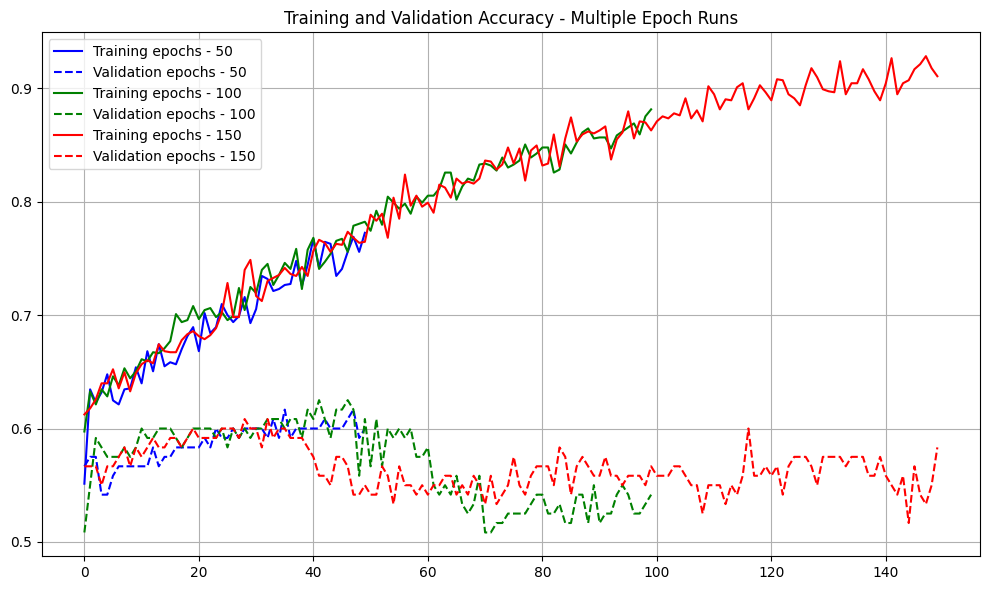

In [20]:
import matplotlib.pyplot as plt

# Assuming you have `history1`, `history2`, and `history3` from different training runs

# Data from first run
acc1 = history1.history['accuracy']
val_acc1 = history1.history['val_accuracy']
epochs1 = range(len(acc1))

# Data from second run
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']
epochs2 = range(len(acc2))

# Data from third run
acc3 = history3.history['accuracy']
val_acc3 = history3.history['val_accuracy']
epochs3 = range(len(acc3))
plt.figure(figsize=(10, 6))
plt.grid(True)
# Plot training and validation accuracy for all runs
plt.plot(epochs1, acc1, 'b', label=f'Training epochs - {nb_epoch_1}')
plt.plot(epochs1, val_acc1, 'b--', label=f'Validation epochs - {nb_epoch_1}')

plt.plot(epochs2, acc2, 'g', label=f'Training epochs - {nb_epoch_2}')
plt.plot(epochs2, val_acc2, 'g--', label=f'Validation epochs - {nb_epoch_2}')

plt.plot(epochs3, acc3, 'r', label=f'Training epochs - {nb_epoch_3}')
plt.plot(epochs3, val_acc3, 'r--', label=f'Validation epochs - {nb_epoch_3}')

plt.title(f'Training and Validation Accuracy - Multiple Epoch Runs')
plt.legend()
plt.tight_layout()
plt.savefig(f'Train_val_acc_multiple_runs_Epochs.png')
plt.show()

## Model evaluation

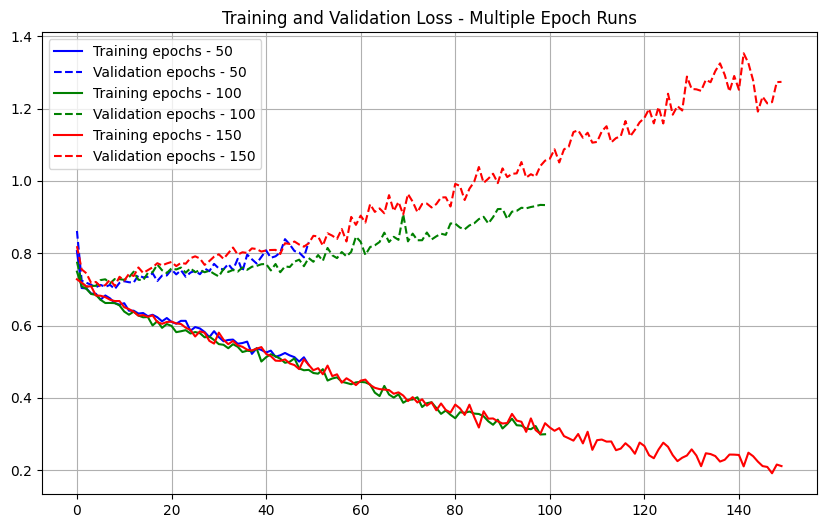

In [18]:
# Data from first run
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']
# Data from second run
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

# Data from third run
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

# Plot training and validation loss for all runs
plt.figure(figsize=(10, 6))
plt.grid(True)
# Plot training and validation accuracy for all runs
plt.plot(epochs1, loss1, 'b', label=f'Training epochs - {nb_epoch_1}')
plt.plot(epochs1, val_loss1, 'b--', label=f'Validation epochs - {nb_epoch_1}')

plt.plot(epochs2, loss2, 'g', label=f'Training epochs - {nb_epoch_2}')
plt.plot(epochs2, val_loss2, 'g--', label=f'Validation epochs - {nb_epoch_2}')

plt.plot(epochs3, loss3, 'r', label=f'Training epochs - {nb_epoch_3}')
plt.plot(epochs3, val_loss3, 'r--', label=f'Validation epochs - {nb_epoch_3}')

plt.title(f'Training and Validation Loss - Multiple Epoch Runs')
plt.legend()
plt.savefig(f'Train_val_loss_multiple_runs.png')
plt.show()

In [22]:
# Function to calculate accuracy and misclassification
def calculate_accuracy(ypred, ytest):
    total = 0
    accurate = 0
    accurateindex = []
    wrongindex = []

    for i in range(len(ypred)):
        if np.argmax(ypred[i]) == np.argmax(ytest[i]):
            accurate += 1
            accurateindex.append(i)
        else:
            wrongindex.append(i)
        total += 1

    accuracy = round(accurate / total * 100, 3)
    return total, accurate, total - accurate, accuracy, accurateindex, wrongindex

In [24]:

# Axial plane accuracy
total1, accurate1, wrong_1, accuracy_1, accurateindex_axial, wrongindex_axial = calculate_accuracy(predictions_valid1, axial_mensicus_label_val)
print(' - Total test data:', total1, '\tAccurately predicted data:', accurate1, '\tWrongly predicted data:', wrong_1)
print(f'{nb_epoch_1} epochs Accuracy:', accuracy_1, '%')

# Axial plane accuracy
total2, accurate2, wrong_2, accuracy_2, accurateindex_axial, wrongindex_axial = calculate_accuracy(predictions_valid2, axial_mensicus_label_val)
print(' - Total test data:', total2, '\tAccurately predicted data:', accurate2, '\tWrongly predicted data:', wrong_2)
print(f'{nb_epoch_2} epochs Accuracy:', accuracy_2, '%')

total3, accurate3, wrong_3, accuracy_3, accurateindex_axial, wrongindex_axial = calculate_accuracy(predictions_valid3, axial_mensicus_label_val)
print(' - Total test data:', total3, '\tAccurately predicted data:', accurate3, '\tWrongly predicted data:', wrong_3)
print(f'{nb_epoch_3} epochs Accuracy:', accuracy_3, '%')

 - Total test data: 120 	Accurately predicted data: 72 	Wrongly predicted data: 48
50 epochs Accuracy: 60.0 %
 - Total test data: 120 	Accurately predicted data: 65 	Wrongly predicted data: 55
100 epochs Accuracy: 54.167 %
 - Total test data: 120 	Accurately predicted data: 70 	Wrongly predicted data: 50
150 epochs Accuracy: 58.333 %
